# CraterFinder
### Dr. Carrie Nugent  
### Aurora Bunten and Filipe Borba  
### Franklin W. Olin College of Engineering  @ Astronomy and Statistics  

Our project focuses on creating a computer program that uses Machine Learning to classify craters in images of different space objects. We want to be able to feed the program a large number of images of a certain terrain and get whether or not there is a crater present in the image with high accuracy. Our goal is to understand more about Tensorflow and Keras, as well as Machine Learning projects in general.

Impact crater counting is important for studying the age and environment (erosion, deposition, resurfacing, etc) of surfaces of planets. The amount of craters from any given time period give us information about the environment of the solar system at that time (Di, Li, Yue, Sun, & Liu, 2014).  

Today we have several different orbiters and other projects that aim to gather high-resolution images of cosmic bodies for professionals to study. These devices, such as the, Lunar Reconnaissance Orbiter (LRO), gather more and more data every day, but humans can’t keep up with the amount and analyze all of it. For instance, the Barlow catalogue (N. G. Barlow, 1988), a published Martian crater catalogue, used images of more than 42,284 craters from the Martian surface. Years later, the Robbins catalogue (Robbins and Hinek, 2012) stores 384,343 craters extracted from high-resolution images of the Thermal Emission Imaging System.  

Traditionally, studies were conducted through manual and visual inspection of images, but counting craters is a very time-consuming and tiresome task. With that in mind, scientists had to come up with a way to do this job in a more efficient manner and Machine Learning was one of the solutions. Machine Learning has some different approaches; the one that will be used in this project is Deep Learning. The more common approach is one using Supervised Learning (Di, Li, Yue, Sun, & Liu, 2014; Stepinski, Mendenhall, & Bue, 2009) in which the algorithm is given a certain set of parameters to search for and then autonomously searches data for those parameters. These are traditionally more reliable as they are easy to compare with human detected crater data sets. Using Deep Learning (Silburt, et al., 2018), which is feeding an algorithm a ton of data without any parameters and letting it create its own patterns, is much less common.



In [0]:
%matplotlib inline
from google.colab import files
import os
import random

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical # One-hot encoding

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

# Sklearn
from sklearn.model_selection import train_test_split # Helps with organizing data for training
from sklearn.metrics import confusion_matrix # Helps present results

print(tf.__version__)

Using TensorFlow backend.


1.13.1


## Loading Data

Our dataset was generated using the [WAC Global Morphologic Mosaic](http://wms.lroc.asu.edu/lroc/view_rdr/WAC_GLOBAL). We selected the 256 pixels per degree option and downloaded each square tile that appears on the screen. There are 8 in total. Their filenames should be similar to "WAC_GLOBAL_E300N0450_256P". With that, we used the Python library image_slicer to slice each image into 360 smaller images and then used image_labeler.py (available on Github) to classify each image manually.

The final dataset consists of 2116 images of areas with craters and 769 images of areas without craters. Since they were manually classified and in a big batch, they are prone to error. Moreover, in the case of craters split in two images (half a crater in one image and the other half in another image), we count both images as areas with craters. In other words, we look at the images individually, if there are signs of craters, then its classified as a crater image.

## Issues with the Data

The accuracy of our model is affected by a few major factors. 

These are the main two:

1. Small Data Set 


*   The size of only about 3000 images is too small to accurately train our model. With more images we would be able to have more craters with different characteristics and the model would learn what all of these were and make them parameters. As of now, our data set doesn't have enough craters so the unusual looking ones won't get classified.


2.  Too many craters


*   As stated above, there was a ratio of 2116 crater to 769 non crater images, which would skew the results more positively. To counter this, we limited the amount of crater images input to 1000 random images so that the comparison would be more accurate. However, this just decreased the data set size. Also, images that covered less area of the moon, with fewer craters or other features in them, would lead to more accuracy as they could be classified better.


3. Mislabeling images
 

*   We also had to classify all of the images manually, which is prone to human error. The lighting and the perceived distortion of size made this process difficult as sometimes it was hard to tell a crater vs another feature such as a mountain. This misleads the model into learning wrong features or tuning the parameters in another direction.  


## Overview of Following Code

- Load images
- Some validation
- Preparing the images for training
- Use of train_test_split


In [0]:
# Unzip images, ignore this cell if files are already in the workspace
!unzip single_crater.zip

In [0]:
root = "./single_crater_rename"
# We need to get all the paths for the images to later load them
imagepaths = []
files = os.listdir(root) # Lists files in workspace
for f in files:
  if f.endswith("png"): # We want only the images
    imagepaths.append(f)

len(imagepaths) # If > 0, then a PNG image was loaded

2887

In [0]:
# This function is used more for debugging and showing results later. It plots the image into the notebook

def plot_image(path):
  img = cv2.imread(root + "/" + path) # Reads the image into a numpy.array
  img_cvt = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Converts into the corret colorspace (RGB)
  print(img_cvt.shape) # Prints the shape of the image just to check
  plt.grid(False) # Without grid so we can see better
  plt.imshow(img_cvt) # Shows the image
  plt.xlabel("Width")
  plt.ylabel("Height")
  plt.title("Image" + path)

(808, 1212, 3)


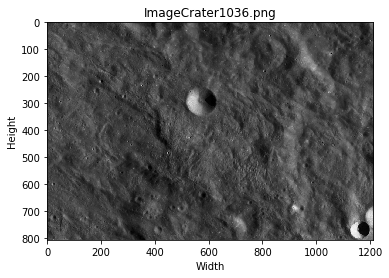

In [0]:
plot_image(imagepaths[0]) #We plot the first image from our imagepaths array

Now that we loaded the images and checked if it's everything we expected, we have to prepare the images to train the algorithm. We have to load all the images into an array that we will call __X__ and all the labels (crater/non-crater) into another array called **y**.

In [0]:
X = [] # Image data
y = [] # Labels

i = 0
for path in imagepaths:
  
  img = cv2.imread(root + "/" + path) # Reads image and returns np.array
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Converts into the corret colorspace (RGB)
  img = cv2.resize(img, (128, 128)) # All images have to be the same size, so we resize them
  
  label = path.split(".png")[0] # Get the file name that contains the image's label
  
  if label[:6] == "Crater": # [:6] to check if string is 'Crater'
    if i < 1000: # Limit the number of Crater images here.
      y.append(1) # If crater, value is 1
      X.append(img) # Append to X
      i += 1
  else:
    y.append(0) # If non crater, value is 0
    X.append(img) # Append to X
  
# Turn X and y into np.array to speed up train_test_split
X = np.array(X, dtype="uint8")
y = np.array(y)

print("Images loaded: ", len(X))
print("Labels loaded: ", len(y))

print(y[0], imagepaths[0])

Images loaded:  1770
Labels loaded:  1770
1 Crater1036.png


Scipy's train_test_split allows us to split our data into a training set and a test set. The training set will be used to build our model. Then, the test data will be used to check if the model predicts if the image is a crater or not.  A random_state seed is used so the randomness of our results can be reproducted. The function will shuffle the images it's using to minimize training loss.


In [0]:
ts = 0.3 # Percentage of images that we want to use for testing. The rest is used for training.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=42)

## Creating Model

https://www.tensorflow.org/tutorials/keras/save_and_restore_models

To simplify the idea of the model being constructed here, we're going to use the concept of Linear Regression. By using linear regression, we can create a simple model and represent it using the equation ```y = ax + b```.  
```a``` and ```b``` (slope and intercept, respectively) are the parameters that we're trying to find. By finding the best parameters, for any given value of x, we can predict y. This is the same idea here, but much more complex, with the use of Convolutional Neural Networks.

A Convolutional Neural Network (ConvNet/CNN) is a Deep Learning algorithm which can take in an input image, assign importance (learnable weights and biases) to various aspects/objects in the image and be able to differentiate one from the other. The pre-processing required in a ConvNet is much lower as compared to other classification algorithms. While in primitive methods filters are hand-engineered, with enough training, ConvNets have the ability to learn these filters/characteristics.

<img src="./imgs/network_example.jpg" alt="CNN example" style="width: 50%;">
Figure 1 - Example of Convolutional Neural Network.

From Figure 1 and imagining the Linear Regression model equation that we talked about, we can imagine that the input layer is x and the output layer is y. The hidden layers vary from model to model, but they are used to "learn" the parameters for our model. Each one has a different function, but they work towards getting the best "slope and intercept".


## Overview of Following Code

- Import what the need
- Creation of CNN
- Compiling and training model
- Saving model for later use

In [0]:
# Recreate the exact same model, including weights and optimizer.
# model = keras.models.load_model('mooncounter_model.h5')
# model.summary()

# To use the pre-trained model, just load it and skip to the next session.

In [0]:
# Import of keras model and hidden layers for our convolutional network
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten, Dropout

Convolutional neural networks (CNNs) are the current state-of-the-art model architecture for image classification tasks. CNNs apply a series of filters to the raw pixel data of an image to extract and learn higher-level features, which the model can then use for classification. CNNs contains three components:

- Convolutional layers, which apply a specified number of convolution filters to the image. For each subregion, the layer performs a set of mathematical operations to produce a single value in the output feature map. Convolutional layers then typically apply a ReLU activation function to the output to introduce nonlinearities into the model.

- Pooling layers, which downsample the image data extracted by the convolutional layers to reduce the dimensionality of the feature map in order to decrease processing time. A commonly used pooling algorithm is max pooling, which extracts subregions of the feature map (e.g., 2x2-pixel tiles), keeps their maximum value, and discards all other values.

- Dense (fully connected) layers, which perform classification on the features extracted by the convolutional layers and downsampled by the pooling layers. In a dense layer, every node in the layer is connected to every node in the preceding layer.

https://www.tensorflow.org/tutorials/estimators/cnn

In [0]:
# Construction of model
model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape=(128, 128, 3), activation='relu'))
model.add(Conv2D(32, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (1, 1), activation='relu'))
model.add(Conv2D(256, (1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.2, seed=42))
model.add(Conv2D(512, (1, 1), activation='relu'))
model.add(Conv2D(512, (1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Our Convolutional Neural Network consists of different layers that have different functions. As explained before, the Conv2D layer performs a 2-D convolutional operation, which can be basically interpreted as a mathematical operation to calculate weights inside the image. In order to maximize the network's performance, we need to understand the parameters required by them.

The first required by the Conv2D layer is the number of filters that the convolutional layer will learn. Layers early in the network architecture (closer to the actual input image) learn fewer convolutional filters while layers deeper in the network (closer to the output predictions) will learn more filters. This permits information to flow through the network without loss. These filters emulate edge detectors, blob detectors and other feature extraction methods.
It is necessary to tune the values of the filters, but it is common practice to use powers of 2, starting with 32, 64, 128 and increasing to 256, 512, 1024, for example.

<img src="./imgs/conv_example.png" alt="Example of 2D Convolution operation" style="width: 50%;">

Figure 2 - Example of 2d convolution operation.

Another parameter required by the Conv2D layer is the kernel_size, a 2-tuple specifying the width and height of the 2D convolution window. The kernel_size must be an odd integer, with typical values of (1, 1) , (3, 3) , (5, 5) , (7, 7) . It’s rare to see kernel sizes larger than 7×7. If the input images are greater than 128×128 it is recommended to test a kernel size > 3 to help learn larger spatial filters and to help reduce volume size.

Then, MaxPooling2D is used to reduce the spatial dimensions of the output volume. It reduces processing time and allows assumptions to be made about features contained in the sub-regions binned. It is possible to notice in this network that our output spatial volume is decreasing and our number of filters learned is increasing. This is a common practice in designing CNN architectures.

Finally, ReLU stands for rectified linear unit, and is a type of activation function. ReLU is the most commonly used activation function in neural networks, especially in CNNs. ReLU is linear (identity) for all positive values, and zero for all negative values. This means that it's cheap to compute as there is no complicated math. The model can therefore take less time to train or run. Also, it converges faster by applying non-linearities to the model, so there is no 'vanishing gradient problem' suffered by other activation functions like sigmoid or tanh.

In the end, there is a lot of trial and error to get the best parameters and network architecture. These are some common practices that help reach the best result faster.

In [0]:
# Configures the model for training
model.compile(optimizer='adam', # Optimization routine, which tells the computer how to adjust the parameter values to minimize the loss function.
              loss='sparse_categorical_crossentropy', # Loss function, which tells us how bad our predictions are.
              metrics=['accuracy']) # List of metrics to be evaluated by the model during training and testing.

In [0]:
# Trains the model for a given number of epochs (iterations on a dataset) and validates it.
training = model.fit(X_train, y_train, epochs=60, verbose=2, validation_data=(X_test, y_test))

Instructions for updating:
Use tf.cast instead.
Train on 1239 samples, validate on 531 samples
Epoch 1/60
 - 7s - loss: 0.9437 - acc: 0.5545 - val_loss: 0.6592 - val_acc: 0.5800
Epoch 2/60
 - 2s - loss: 0.6642 - acc: 0.6199 - val_loss: 0.6615 - val_acc: 0.5932
Epoch 3/60
 - 2s - loss: 0.6346 - acc: 0.6416 - val_loss: 0.6354 - val_acc: 0.6328
Epoch 4/60
 - 2s - loss: 0.6136 - acc: 0.6602 - val_loss: 0.6332 - val_acc: 0.6422
Epoch 5/60
 - 2s - loss: 0.5901 - acc: 0.6852 - val_loss: 0.6870 - val_acc: 0.5951
Epoch 6/60
 - 2s - loss: 0.6163 - acc: 0.6538 - val_loss: 0.6611 - val_acc: 0.6648
Epoch 7/60
 - 2s - loss: 0.5679 - acc: 0.6998 - val_loss: 0.5889 - val_acc: 0.6930
Epoch 8/60
 - 2s - loss: 0.5499 - acc: 0.7046 - val_loss: 0.6168 - val_acc: 0.6742
Epoch 9/60
 - 2s - loss: 0.5538 - acc: 0.6973 - val_loss: 0.6071 - val_acc: 0.6949
Epoch 10/60
 - 2s - loss: 0.5258 - acc: 0.7345 - val_loss: 0.6217 - val_acc: 0.6949
Epoch 11/60
 - 2s - loss: 0.4901 - acc: 0.7474 - val_loss: 0.6323 - val_ac

The output of each epoch is important because it gives an overview on how the model is progressing over every iteration on the dataset. For each line, the output is:

- Time spent processing - Sum of all prediction errors - Accuracy of the train | Errors and accuracy for test set

We want the loss to be the lowest and the accuracy to be the highest as possible.

In [0]:
# Save entire model to a HDF5 file
model.save('mooncounter_model.h5')

## Testing Model

Now that we have the model compiled and trained, we need to check if it's good. First, we run ```model.evaluate``` to test the accuracy. Then, we make predictions and plot the images as long with the predicted labels and true labels to check everything. With that, we can see how our algorithm is working.  
Later, we produce a confusion matrix, which is a specific table layout that allows visualization of the performance of an algorithm. 


- Evaluate model
- Predictions
- Plot images with predictions
- Visualize model

In [0]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy: {:2.2f}%'.format(test_acc*100))

531/531 [==============================] - 0s 604us/step
Test accuracy: 73.26%


In [0]:
predictions = model.predict(X_test) # Make predictions towards the test set

In [0]:
np.argmax(predictions[0]), np.argmax(y_test[0]) # If same, got it right

(1, 0)

In [0]:
# Function to plot images and labels for validation purposes
def validate_9_images(predictions_array, true_label_array, img_array):
  # Array for pretty pretty printing and then figure size
  class_names = ['NoCrater', 'Crater']
  plt.figure(figsize=(15,15))
  
  for i in range(1, 10):
    # Just assigning variables
    prediction = predictions_array[i]
    true_label = true_label_array[i]
    img = img_array[i]
    
    # Plot in a good way
    plt.subplot(3,3,i)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(prediction) # Get index of the predicted label from prediction
    
    # Change color of title
    if predicted_label == true_label:
      color = 'blue'
    else:
      color = 'red'

    plt.xlabel("Predicted: {} {:2.0f}% (True: {})".format(class_names[predicted_label],
                                  100*np.max(prediction),
                                  class_names[true_label]),
                                  color=color)
  plt.show()

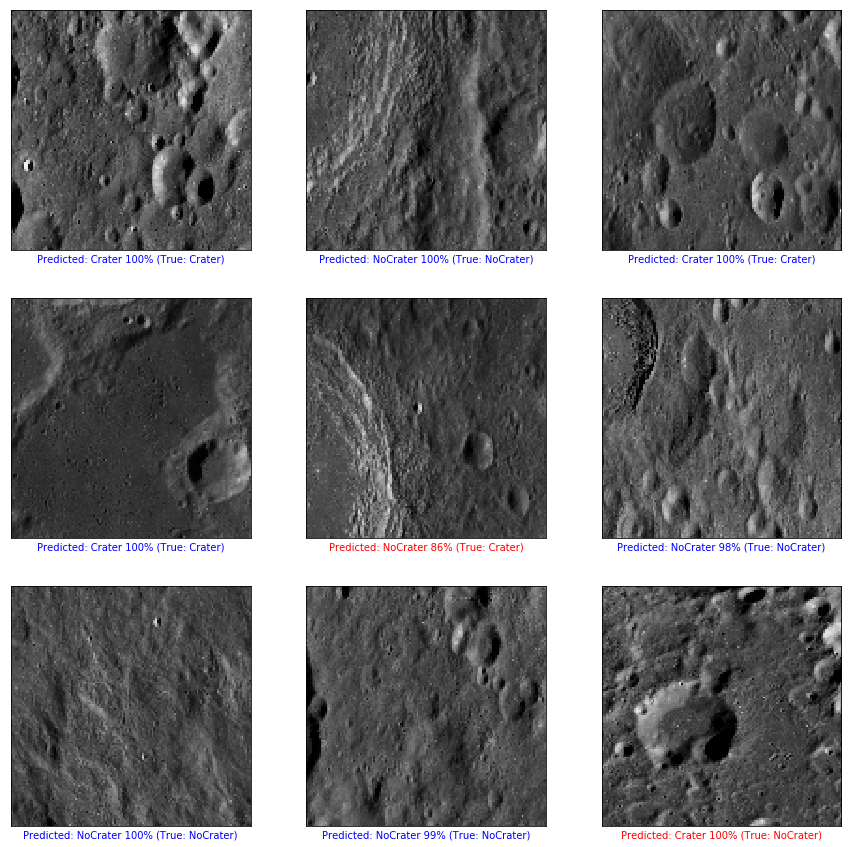

In [0]:
validate_9_images(predictions, y_test, X_test)

Here we plot a few images and check the true label and predicted label. If the result is in blue, then the algorithm got it right; if red, then it's wrong. We use that to check if the images are consistent with the labels and results.

In [0]:
y_pred = np.argmax(predictions, axis=1) # Transform predictions into 1-D array with label number

In [0]:
pd.DataFrame(confusion_matrix(y_test, y_pred), 
             columns=["Predicted Not-Crater", "Predicted Crater"],
             index=["Actual Not-Crater", "Actual Crater"])

,Predicted Not-Crater,Predicted Crater
Actual Not-Crater,148,75
Actual Crater,67,241


This confusion matrix allows us to check the accuracy of our model in terms of individual test results. With that, we can get a more broad sense of the false positives/negatives of our model and determine how it is skewed.

> Column | Value
>--- | ---
> True Positive | 148
> False Positive | 75
> False Negative | 67
> True Negative | 241

Some metrics are used to understand how our model is working:

The positive and negative predictive values (PPV and NPV respectively) are the proportions of positive and negative results in statistics and diagnostic tests that are true positive and true negative results, respectively. The PPV and NPV describe the performance of a diagnostic test or other statistical measure. A high result can be interpreted as indicating the accuracy of such a statistic.

Sensitivity (also called the true positive rate or the recall) measures the proportion of actual positives that are correctly identified as such (e.g., the percentage of sick people who are correctly identified as having the condition). Specificity (also called the true negative rate) measures the proportion of actual negatives that are correctly identified as such (e.g., the percentage of healthy people who are correctly identified as not having the condition).

- PPV = TP / (TP+FP) = 66.36%  
- NPV = TN / (TN+FN) = 78.24%  
- Sensitivity = TP / (TP+FN) = 68.83%  
- Specificity = TN / (TN + FP) = 76.26%    

All of these metrics follow the "higher is better" idea. As we can see, our model is better at classifying not craters, because it has a higher NPV and specificity.

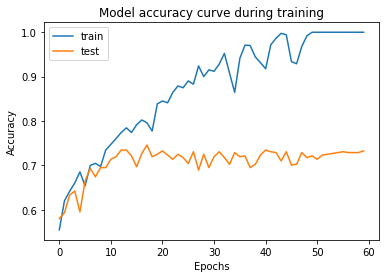

In [0]:
# Summarize history for accuracy
plt.plot(training.history['acc']) # Accuracy values for training
plt.plot(training.history['val_acc']) # Accuracy values for testing
plt.title('Model accuracy curve during training')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Here we can see how our accuracy changes overtime while both training and testing the model. The training accuracy gets higher as the algorithm iterates over it several times, understanding all the craters' features. Thus the model is easily fit to the images. On the other hand, the model only runs the testing images once to check if it's right or wrong without becoming biassed. We can see that there's a ceiling of about 75%.

---



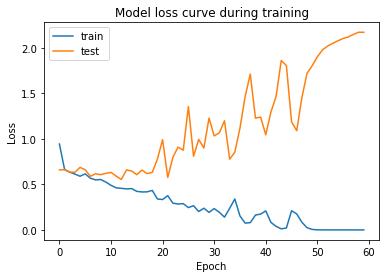

In [0]:
# Summarize history for loss
plt.plot(training.history['loss']) # Loss values for training
plt.plot(training.history['val_loss']) # Loss values for testing
plt.title('Model loss curve during training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

This graph reflects the same idea as the previous one. It's easier to get a lower loss for training, but this isn't true for testing. In fact, the loss increases over time, which means that the disparity of the data isn't high, representing that it's more difficult to classify the images.  
As we can see from the model.fit output, the loss of the model isn't necessarily as directly proportional to the accuracy. Sometimes a model with a little more loss can have a better accuracy than another. That happens because of the very similar features in all pictures, making it hard to get the right features to be accounted for.

Any doubts? Feel free to send questions/issues on [Github](https://github.com/filipefborba/AstroStats)!